In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import re
import tqdm
import time
import sys
import logging
from tqdm.auto import tqdm
from typing import List, Dict
from data.make_data import get_links, is_article, save_links, extract_links, get_date_from_url, extract_links_main

sys.path.append('../hot_links')
# TODO Something like this in dataset.py
# from hot_links.config import PROCESSED_DATA_DIR, RAW_DATA_DIR

from hot_links.vector_db_utils import *

np.random.seed(41)
logger = logging.getLogger(__name__)


In [ ]:
# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/bbc-news-articles")

print("Path to dataset files:", path)

In [ ]:
df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "adityakharosekar2/guardian-news-articles",
    'guardian_articles.csv'
)

In [ ]:
df.head()

,article_id,sectionName,webTitle,webUrl,bodyContent,webPublicationDate,id
0,us-news/2016/jan/31/iowa-caucus-underdog-candi...,US news,Iowa underdogs put on brave faces despite all ...,https://www.theguardian.com/us-news/2016/jan/3...,As polling day looms and the cameras turn only...,2016-01-31T23:53:37Z,1
1,us-news/2016/jan/31/iowa-caucus-worlds-most-pa...,US news,Iowa caucus: hologram eagle and Jesus star on ...,https://www.theguardian.com/us-news/2016/jan/3...,"In Des Moines on Sunday, the Guardian was give...",2016-01-31T23:46:28Z,2
2,world/2016/jan/31/tanzania-britsh-helicopter-p...,World news,British pilot in Tanzania 'manoeuvred ​to save...,https://www.theguardian.com/world/2016/jan/31/...,A British pilot who was shot dead by an elepha...,2016-01-31T23:43:48Z,3
3,football/2016/jan/31/late-winner-gets-usa-off-...,Football,USA 3-2 Iceland | International friendly match...,https://www.theguardian.com/football/2016/jan/...,USA took a step toward shaking off the ghosts ...,2016-01-31T23:30:49Z,4
4,football/2016/jan/31/blackburn-paul-lambert-ox...,Football,Reinvigorated Paul Lambert reflects after impr...,https://www.theguardian.com/football/2016/jan/...,"The clean-shaven, spectacle free and suspiciou...",2016-01-31T22:30:10Z,5


In [ ]:
df.to_csv('../data/raw/gurdian_articles.csv', index=False)

In [3]:
df = pd.read_csv('../data/raw/gurdian_articles.csv')

In [4]:
df.head()

,article_id,sectionName,webTitle,webUrl,bodyContent,webPublicationDate,id
0,us-news/2016/jan/31/iowa-caucus-underdog-candi...,US news,Iowa underdogs put on brave faces despite all ...,https://www.theguardian.com/us-news/2016/jan/3...,As polling day looms and the cameras turn only...,2016-01-31T23:53:37Z,1
1,us-news/2016/jan/31/iowa-caucus-worlds-most-pa...,US news,Iowa caucus: hologram eagle and Jesus star on ...,https://www.theguardian.com/us-news/2016/jan/3...,"In Des Moines on Sunday, the Guardian was give...",2016-01-31T23:46:28Z,2
2,world/2016/jan/31/tanzania-britsh-helicopter-p...,World news,British pilot in Tanzania 'manoeuvred ​to save...,https://www.theguardian.com/world/2016/jan/31/...,A British pilot who was shot dead by an elepha...,2016-01-31T23:43:48Z,3
3,football/2016/jan/31/late-winner-gets-usa-off-...,Football,USA 3-2 Iceland | International friendly match...,https://www.theguardian.com/football/2016/jan/...,USA took a step toward shaking off the ghosts ...,2016-01-31T23:30:49Z,4
4,football/2016/jan/31/blackburn-paul-lambert-ox...,Football,Reinvigorated Paul Lambert reflects after impr...,https://www.theguardian.com/football/2016/jan/...,"The clean-shaven, spectacle free and suspiciou...",2016-01-31T22:30:10Z,5


In [4]:
df["webPublicationDate"] = df["webPublicationDate"].apply(pd.to_datetime)

In [5]:
df.sort_values('webPublicationDate',ascending=False,inplace=True)
# Sort to have most recent at the top

In [6]:
df.groupby([df["webPublicationDate"].dt.year])['id'].count()#.plot(kind="bar")
# Articles are split across 6 years

webPublicationDate
2016    23215
2017    23125
2018    23057
2019    23047
2020    22980
2021    22915
2022    11500
Name: id, dtype: int64

<Axes: >

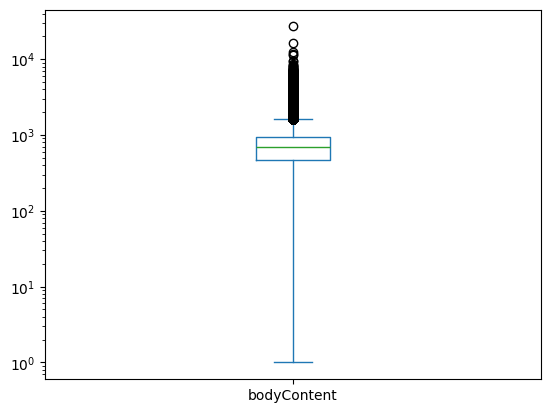

In [11]:
df['bodyContent'].apply(lambda x:len(str(x).split(' '))).plot(kind = 'box', logy=True)
# Coerce content to string and get length dist
# OpenAI semantic search limited to 4086 chars

<Axes: >

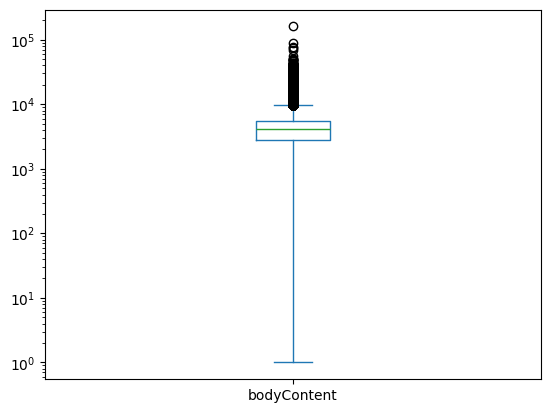

In [14]:
df['bodyContent'].apply(lambda x:len(str(x))).plot(kind = 'box',logy=True)

In [ ]:
df[df['bodyContent'].apply(lambda x:len(str(x))) > 4096].shape[0] / df.shape[0]
# Quite a few articles over 4096 chars

0.5118961018159491

In [6]:
df = df[df['webPublicationDate'].dt.year < 2017]
# Let's focus on 2016 for now

In [21]:
df.shape

(23215, 7)

## Define a seed set

In [7]:
n_seed = 1000

In [8]:
df_seed = df.iloc[int(df.shape[0]/2):(int(df.shape[0]/2) + n_seed)]
# Choose from the middle

In [9]:
trash = df_seed.head()[['webUrl', 'id']].apply(get_links, axis=1)

In [10]:
trash

73512    {'url': 'https://www.theguardian.com/global-de...
73513    {'url': 'https://www.theguardian.com/world/201...
73514    {'url': 'https://www.theguardian.com/politics/...
73515    {'url': 'https://www.theguardian.com/artanddes...
73516    {'url': 'https://www.theguardian.com/sport/201...
dtype: object

In [10]:
# create_vs('test_vs')
vector_store_id = get_vector_store_id(vs_name = 'test_vs')

In [65]:
tqdm.auto.tqdm.pandas()

all_article_links = []
# Here we store all the lists of dicts of links for all seed articles

for row in tqdm.tqdm(df_seed.sample(50).iterrows()):
    seed_article = row[1]
    attributes = {'date' : convert_date_to_epoch(seed_article['webPublicationDate']), 'generation' : 0}
    file_id = push_file_to_cloud('test_' + seed_article['webUrl'], seed_article['bodyContent'])
    add_file_to_db(file_id, vector_store_id, attributes = attributes)
    
    seed_article_links = list(filter(lambda x: is_article(x['href']), extract_links_main(seed_article['webUrl'])))
    # List of dicts {'href' = <>, 'link' = ''}
    
    all_article_links.append(seed_article_links)
    # TODO persist links somewhere
    
    seed_article_links_dates = map(get_date_from_url, map(lambda x: x['href'], seed_article_links))
    
    # TODO get content of the linked articles

all_article_links_flat = [item['href'] for sublist in all_article_links for item in sublist]
# This is the list of URLs for the next gen of snowball sampling

all_article_links_flat_unique = list(set(all_article_links_flat))

# df_seed['links'] = pd.Series(all_article_links)


0it [00:00, ?it/s]

50it [01:34,  1.90s/it]


In [75]:
print('Parsed {:d} articles, giving {:d} new links \n{:d} unique {:.2f}% for next gen\n{:.1f} on average'.format(len(all_article_links),\
    len(all_article_links_flat),len(all_article_links_flat_unique),100*(len(all_article_links_flat_unique)/len(all_article_links_flat)),(len(all_article_links_flat_unique)/len(all_article_links))))

Parsed 119 articles, giving 332 new links 
298 unique 89.76% for next gen
2.5 on average


In [67]:
df_snowball = pd.DataFrame(columns=['url','date','links','content'])
all_article_links = []

for url in tqdm.tqdm(all_article_links_flat[:-1]):
    # print(url)
    # TODO check we haven't parsed the article before in previous generation(s)
    
    attributes = {'date' : convert_date_to_epoch(get_date_from_url(url)), 'generation' : 1}
    #print()
    
    links, content = extract_links_main(url,get_content=True)
    
    if len(content) > 0:
    
        links = list(filter(lambda x: is_article(x['href']),links))
        all_article_links.append(links)
        
        file_id = push_file_to_cloud('test_' + url, content)
        add_file_to_db(file_id, vector_store_id, attributes = attributes)
        #print()
        
        new_row = pd.DataFrame([{"url": url, "date": attributes['date'], "links": links,'content' : content}])
        df_snowball = pd.concat([df_snowball, new_row], ignore_index=True)
    else:
        print('Skipping, probably not a proper article')
        print(url)

all_article_links_flat = [item['href'] for sublist in all_article_links for item in sublist]
# This is the list of URLs for the next gen of snowball sampling

all_article_links_flat_unique = list(set(all_article_links_flat))

  3%|▎         | 4/126 [00:05<02:42,  1.33s/it]

Skipping, probably not a proper article
https://www.theguardian.com/politics/ng-interactive/2016/jun/23/eu-referendum-live-results-and-analysis


  5%|▍         | 6/126 [00:09<02:44,  1.37s/it]

Skipping, probably not a proper article
https://www.theguardian.com/world/video/2016/jun/28/scottish-mep-given-standing-ovation-in-eu-parliament-video


  6%|▌         | 7/126 [00:09<02:16,  1.15s/it]

Skipping, probably not a proper article
https://www.theguardian.com/politics/video/2016/jun/24/nicola-sturgeon-second-scottish-independence-referendum-on-the-table-video


 13%|█▎        | 17/126 [00:28<02:49,  1.56s/it]

Skipping, probably not a proper article
https://www.theguardian.com/global/video/2016/jun/27/project-fear-over-says-boris-johnson-video


 47%|████▋     | 59/126 [01:59<01:51,  1.67s/it]

Skipping, probably not a proper article
https://www.theguardian.com/world/video/2016/jun/29/what-is-article-50-brexit-video-explainer


 80%|████████  | 101/126 [03:33<00:36,  1.46s/it]

Skipping, probably not a proper article
https://www.theguardian.com/politics/video/2016/jun/29/stephen-crabb-im-running-for-incredibly-difficult-tory-leader-job-video


 82%|████████▏ | 103/126 [03:36<00:30,  1.32s/it]

Skipping, probably not a proper article
https://www.theguardian.com/australia-news/video/2016/jun/28/australia-not-responsible-for-refugees-in-offshore-detention-turnbull-suggests-video


100%|██████████| 126/126 [04:23<00:00,  2.09s/it]


In [64]:
print('Parsed {:d} articles, giving {:d} new links ({:d} unique {:.2f}%) for next gen'.format(len(all_article_links),\
    len(all_article_links_flat),len(all_article_links_flat_unique),100*(len(all_article_links_flat_unique)/len(all_article_links_flat))))

Parsed 162 articles, giving 483 new links (398 unique 82.40%) for next gen


In [72]:
df_snowball['date'].apply(lambda x:datetime.datetime.utcfromtimestamp(x).year).value_counts()

/tmp/ipykernel_731/1407012282.py:1: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df_snowball['date'].apply(lambda x:datetime.datetime.utcfromtimestamp(x).year).value_counts()


date
2016    86
2014    16
2015     8
2010     3
2012     2
2009     2
2013     1
2011     1
Name: count, dtype: int64

In [46]:
df_snowball

,url,date,links,content
0,https://www.theguardian.com/football/2016/jun/...,1465257600,[{'href': 'https://www.theguardian.com/footbal...,Ronald Koeman is expected to be appointed Ever...
1,https://www.theguardian.com/football/blog/2016...,1467244800,[{'href': 'https://www.theguardian.com/footbal...,As Eden Hazard drove out into the Fulham Road ...
2,https://www.theguardian.com/football/2016/jun/...,1467072000,[{'href': 'https://www.theguardian.com/footbal...,Sadio Mané has signed for Liverpool on a five-...
3,https://www.theguardian.com/football/2016/jun/...,1465257600,[{'href': 'https://www.theguardian.com/footbal...,Ronald Koeman is expected to be appointed Ever...
4,https://www.theguardian.com/football/blog/2016...,1467244800,[{'href': 'https://www.theguardian.com/footbal...,As Eden Hazard drove out into the Fulham Road ...
5,https://www.theguardian.com/football/2016/jun/...,1467072000,[{'href': 'https://www.theguardian.com/footbal...,Sadio Mané has signed for Liverpool on a five-...
6,https://www.theguardian.com/football/2016/jun/...,1465862400,[{'href': 'https://www.theguardian.com/footbal...,The pessimistic view when Ronald Koeman moved ...
7,https://www.theguardian.com/football/2016/may/...,1463011200,[{'href': 'https://www.theguardian.com/footbal...,Roberto Martínez has been sacked by Everton af...
8,https://www.theguardian.com/football/2016/mar/...,1458432000,[{'href': 'https://www.theguardian.com/footbal...,For a while it looked as if Liverpool were goi...
9,https://www.theguardian.com/football/2016/jun/...,1466726400,[{'href': 'https://www.theguardian.com/footbal...,Liverpool have been offered encouraging signs ...


In [37]:
links

[{'href': 'https://www.theguardian.com/football/blog/2016/jun/29/england-roy-hodgson-fa-farce-euro-2016',
  'link': 'French farce illustratesEngland’s failure to move with the timesRead more'},
 {'href': 'https://www.theguardian.com/football/blog/2016/jun/28/football-association-martin-glenn-england-manager-selection',
  'link': 'England in disarray as quest for next manager begins after bizarre campaignRead more'},
 {'href': 'https://www.theguardian.com/football/2016/jun/19/england-roy-hodgson-greg-dyke-euro-2016',
  'link': 'if they reached the semi-finals or got to the quarter finals and played well'},
 {'href': 'https://www.theguardian.com/football/2016/jun/28/england-gareth-southgate-roy-hodgson',
  'link': 'Arsene Wenger, among names in the frame'}]

In [35]:
for d in links:
    print(d)
    print(is_article(d['href']))

{'href': 'https://www.theguardian.com/football/blog/2016/jun/29/england-roy-hodgson-fa-farce-euro-2016', 'link': 'French farce illustratesEngland’s failure to move with the timesRead more'}
True
{'href': 'https://www.theguardian.com/football/blog/2016/jun/28/football-association-martin-glenn-england-manager-selection', 'link': 'England in disarray as quest for next manager begins after bizarre campaignRead more'}
True
{'href': 'https://www.theguardian.com/football/2016/jun/19/england-roy-hodgson-greg-dyke-euro-2016', 'link': 'if they reached the semi-finals or got to the quarter finals and played well'}
True
{'href': 'https://www.theguardian.com/football/2016/jun/28/england-gareth-southgate-roy-hodgson', 'link': 'Arsene Wenger, among names in the frame'}
True


In [22]:
extract_links_main('https://www.theguardian.com/world/2019/mar/30/gaza-protests-palestinian-death-israel')

[{'href': 'https://www.theguardian.com/world/2018/may/14/israel-tells-palestinians-they-are-risking-lives-in-us-embassy-protests',
  'link': 'huge numbers of casualties'},
 {'href': 'https://www.theguardian.com/world/gaza', 'link': 'Gaza'},
 {'href': 'https://www.theguardian.com/world/ng-interactive/2019/mar/29/a-year-of-bloodshed-at-gaza-border-protests',
  'link': 'Gaza border protests: 190 killed and 28,000 injured in a year of bloodshedRead more'},
 {'href': 'https://www.theguardian.com/world/2018/mar/30/palestinians-march-to-gaza-border-for-start-of-six-week-protest-israel',
  'link': 'first launched'},
 {'href': 'https://www.ohchr.org/EN/HRBodies/HRC/Pages/NewsDetail.aspx?NewsID=24348&LangID=E',
  'link': 'found'},
 {'href': 'https://www.theguardian.com/world/2019/mar/29/gaza-braces-for-anniversary-of-demonstrations-at-frontier-wth-israel',
  'link': 'Gaza braces for anniversary of demonstrations at frontier with IsraelRead more'},
 {'href': 'https://www.theguardian.com/world/201

In [19]:
df_seed.tail()['webUrl'].values

array(['https://www.theguardian.com/sport/2019/mar/25/ashwin-mankad-buttler-kings-xi-ipl-cricket',
       'https://www.theguardian.com/world/2019/mar/25/joshua-boyle-trial-abuse-claims-afghanistan-kidnapping-family',
       'https://www.theguardian.com/sport/2019/mar/25/michael-schumacher-son-mick-f1-debut-ferrari',
       'https://www.theguardian.com/technology/2019/mar/25/apple-tv-subscription-oprah-winfrey-arcade-credit-card',
       'https://www.theguardian.com/sport/2019/mar/25/robert-garrigus-drugs-ban-pga-anti-doping-policy-only-catch-unknowns'],
      dtype=object)

In [24]:
all_article_links

[[{'href': 'https://www.theguardian.com/global-development/2018/dec/15/uk-care-system-failing-trafficked-children-lost-and-missing',
   'link': 'A recent report'},
  {'href': 'https://www.theguardian.com/global-development/2018/dec/15/uk-care-system-failing-trafficked-children-lost-and-missing',
   'link': 'Hundreds of trafficked children ‘lost’ by local authoritiesRead more'}],
 [{'href': 'https://www.theguardian.com/world/2018/may/14/israel-tells-palestinians-they-are-risking-lives-in-us-embassy-protests',
   'link': 'huge numbers of casualties'},
  {'href': 'https://www.theguardian.com/world/2018/mar/30/palestinians-march-to-gaza-border-for-start-of-six-week-protest-israel',
   'link': 'first launched'},
  {'href': 'https://www.theguardian.com/world/2019/mar/29/gaza-braces-for-anniversary-of-demonstrations-at-frontier-wth-israel',
   'link': 'Gaza braces for anniversary of demonstrations at frontier with IsraelRead more'},
  {'href': 'https://www.theguardian.com/world/2019/mar/26/is

In [27]:
flat_list = [item['href'] for sublist in all_article_links for item in sublist]


In [28]:
flat_list

['https://www.theguardian.com/global-development/2018/dec/15/uk-care-system-failing-trafficked-children-lost-and-missing',
 'https://www.theguardian.com/global-development/2018/dec/15/uk-care-system-failing-trafficked-children-lost-and-missing',
 'https://www.theguardian.com/world/2018/may/14/israel-tells-palestinians-they-are-risking-lives-in-us-embassy-protests',
 'https://www.theguardian.com/world/2018/mar/30/palestinians-march-to-gaza-border-for-start-of-six-week-protest-israel',
 'https://www.theguardian.com/world/2019/mar/29/gaza-braces-for-anniversary-of-demonstrations-at-frontier-wth-israel',
 'https://www.theguardian.com/world/2019/mar/26/israel-hamas-relations-a-predictable-but-fatal-dance',
 'https://www.theguardian.com/politics/2019/mar/30/dominic-grieve-loses-confidence-vote-held-by-beaconsfield-tories',
 'https://www.theguardian.com/football/2017/jan/20/tottenham-hotspur-new-stadium-cheese-white-hart-lane',
 'https://www.theguardian.com/sport/2019/feb/04/cheltenham-festiv

1. Loop through all articles
2. Put them into DB
3. Get all their links
4. Drop all non proper articles i.e. only of URL format https://www.theguardian.com/football/<Year>/<Month>/<Date>/<Title>
5. Save all their links and hrefs in a file
6. Extract dates of linked articles
7. Get content of linked articles
7. Put all the linked articles into DB with meta data
8. Stop here: 1 step snowball

In [14]:
df_seed.iloc[0,]

article_id            football/2016/jun/30/claude-puel-southampton-m...
sectionName                                                    Football
webTitle              Claude Puel’s appointment can help to soothe S...
webUrl                https://www.theguardian.com/football/2016/jun/...
bodyContent           As the man responsible for handing a 16-year-o...
webPublicationDate                            2016-06-30 23:30:00+00:00
id                                                                 9692
Name: 9691, dtype: object

In [19]:
vector_store_id

'vs_68b7174279d48191b4ffd8db1d3739b8'

In [41]:
seed_article = df_seed.iloc[2,]

file_id = push_file_to_cloud('test_' + seed_article['webUrl'], seed_article['bodyContent'])

In [21]:
convert_date_to_epoch(seed_article['webPublicationDate'])

1467329400

In [42]:
attributes = {'date' : convert_date_to_epoch(seed_article['webPublicationDate']), 'generation' : 0}
add_file_to_db(file_id, vector_store_id, attributes = attributes)

VectorStoreFile(id='file-EwepDzTJrymvzbqapw3PvE', created_at=1756831133, last_error=None, object='vector_store.file', status='in_progress', usage_bytes=0, vector_store_id='vs_68b7174279d48191b4ffd8db1d3739b8', attributes={'date': 1467328489.0, 'generation': 0.0}, chunking_strategy=StaticFileChunkingStrategyObject(static=StaticFileChunkingStrategy(chunk_overlap_tokens=400, max_chunk_size_tokens=800), type='static'))

In [43]:
for f in get_files_in_db(vector_store_id):
    print(f)

VectorStoreFile(id='file-EwepDzTJrymvzbqapw3PvE', created_at=1756831132, last_error=None, object='vector_store.file', status='completed', usage_bytes=6740, vector_store_id='vs_68b7174279d48191b4ffd8db1d3739b8', attributes={'date': 1467328489.0, 'generation': 0.0}, chunking_strategy=StaticFileChunkingStrategyObject(static=StaticFileChunkingStrategy(chunk_overlap_tokens=400, max_chunk_size_tokens=800), type='static'))
VectorStoreFile(id='file-7V1kMSMqA9KKr1JuiUbTfj', created_at=1756829784, last_error=None, object='vector_store.file', status='completed', usage_bytes=5786, vector_store_id='vs_68b7174279d48191b4ffd8db1d3739b8', attributes={'date': 1467329400.0, 'generation': 0.0}, chunking_strategy=StaticFileChunkingStrategyObject(static=StaticFileChunkingStrategy(chunk_overlap_tokens=400, max_chunk_size_tokens=800), type='static'))


In [36]:
is_article('https://www.theguardian.com/world/2021/dec/19/ber')

<unknown>:29: SyntaxWarning: invalid escape sequence '\.'


True

In [37]:
is_article('https://www.theguardian.com/football/southampton')

False

In [45]:
trash = list(filter(lambda x: is_article(x['href']), extract_links(seed_article['webUrl'])))

In [46]:
trash

[{'href': 'https://www.theguardian.com/technology/2015/oct/21/tesla-autopilot-goes-wrong-videos',
  'link': 'Tesla’s autopilot mode'},
 {'href': 'https://www.theguardian.com/technology/2015/oct/21/tesla-autopilot-goes-wrong-videos',
  'link': 'What happens when Tesla’s AutoPilot goes wrong: owners post swerving videosRead more'},
 {'href': 'https://www.theguardian.com/technology/2016/may/17/self-driving-trucks-otto-startup',
  'link': 'One startup'},
 {'href': 'https://www.theguardian.com/science/2016/jun/14/statistically-self-driving-cars-are-about-to-kill-someone-what-happens-next',
  'link': 'Statistically, self-driving cars are about to kill someone. What happens next?Read more'}]

In [ ]:
def get_date_from_url(url):
    pattern = re.compile(
    r"^https://www\.theguardian\.com/(?:[a-z-]+/)+"
    r"(20(1[5-9]|2[0-4]))/"              # group 1 = full year
    r"(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)/"  # group 3 = month
    r"(0[1-9]|[12][0-9]|3[01])/"         # group 4 = day
    r"(?:[a-z0-9-]+)(?:/[a-z0-9-]+)*/?(?:[?#].*)?$")
    
    print(url)
    
    match = pattern.match(url.strip())
    #print(match.groups())
    
    if match:
        year = match.group(1)        # "2015"
        month = match.group(3)   # "oct"
        day = match.group(4)         # "21"
        
        #print(year, month, day)
    
        # Parse with strptime
        dt = datetime.datetime.strptime(f"{match.group(1)} {match.group(3)} {match.group(4)}", "%Y %b %d")
        return dt
    else:
        return None

In [87]:
for d in trash:
    print(get_date_from_url(d['href']))

https://www.theguardian.com/technology/2015/oct/21/tesla-autopilot-goes-wrong-videos
2015-10-21 00:00:00
https://www.theguardian.com/technology/2015/oct/21/tesla-autopilot-goes-wrong-videos
2015-10-21 00:00:00
https://www.theguardian.com/technology/2016/may/17/self-driving-trucks-otto-startup
2016-05-17 00:00:00
https://www.theguardian.com/science/2016/jun/14/statistically-self-driving-cars-are-about-to-kill-someone-what-happens-next
2016-06-14 00:00:00


In [39]:
for d in extract_links(seed_article['webUrl']):
    if is_article(d['href']):
        print('\tIs article')
        print(d['href'])
    else:
        #print('Is not article')
        #print(d['href'])
        pass
    #print()

	Is article
https://www.theguardian.com/football/2016/jun/30/southampton-claude-puel-first-team-manager-appoint
	Is article
https://www.theguardian.com/football/2016/jun/30/southampton-claude-puel-first-team-manager-appoint
	Is article
https://www.theguardian.com/football/2016/jun/14/ronald-koeman-everton-manager-confirmed-southampton
	Is article
https://www.theguardian.com/football/2016/jun/26/liverpool-sadio-mane-southampton-transfer


In [11]:
trash.iloc[0]

{'url': 'https://www.theguardian.com/football/2016/jun/30/claude-puel-southampton-manager-thierry-henry',
 'id': '9692',
 'links': [{'href': '#img-1', 'link': 'View image in fullscreen'},
  {'href': 'https://www.theguardian.com/sport/blog', 'link': 'Sportblog'},
  {'href': 'https://www.theguardian.com/football/southampton',
   'link': 'Southampton'},
  {'href': 'https://www.theguardian.com/profile/ed-aarons',
   'link': 'Ed Aarons'},
  {'href': 'mailto:?subject=Claude Puel’s appointment can help to soothe Southampton’s supporters&body=https://www.theguardian.com/football/2016/jun/30/claude-puel-southampton-manager-thierry-henry?CMP=share_btn_url',
   'link': 'Share'},
  {'href': 'https://www.theguardian.com/football/2016/jun/30/southampton-claude-puel-first-team-manager-appoint',
   'link': 'Claude Puel’s appointment'},
  {'href': 'https://www.theguardian.com/football/2016/jun/30/southampton-claude-puel-first-team-manager-appoint',
   'link': 'Southampton appoint Frenchman Claude Puel 

In [54]:
n = 10

test = df.sample(n)[['webUrl', 'id']]

In [ ]:
test_out = test.apply(get_links, metadata = True, axis = 1)

In [59]:
test_out.head()

3027      ({'url': 'https://www.theguardian.com/books/20...
11224     ({'url': 'https://www.theguardian.com/film/201...
148150    ({'url': 'https://www.theguardian.com/sport/20...
57793     ({'url': 'https://www.theguardian.com/world/20...
147283    ({'url': 'https://www.theguardian.com/environm...
dtype: object

In [60]:
df.sample(10).iloc[1,:][['webUrl', 'id']]

webUrl    https://www.theguardian.com/society/2022/may/2...
id                                                   147271
Name: 147270, dtype: object

In [61]:
res = get_links(df.sample(10).iloc[1,:][['webUrl', 'id']])

for l in res['links']:
    if is_article(l['href']):
        print(l['href'], l['link'])

https://www.theguardian.com/education/academies Academies
https://www.theguardian.com/profile/richardadams Richard Adams
https://www.theguardian.com/profile/caelainn-barr Caelainn Barr
https://www.theguardian.com/teacher-network/2016/sep/01/ask-the-experts-do-multi-academy-trusts-really-improve-school-results multi-academy trusts
https://www.theguardian.com/education/2018/jan/22/rose-hill-primary-oxford-an-orphan-school-at-the-sharp-end-of-academisation ‘We feel unwanted’: an ‘orphan’ school at the sharp end of academisationRead more
https://www.theguardian.com/education/schools Schools
https://www.theguardian.com/education/2017/oct/21/collapsing-wakefield-city-academies-trust-asset-stripped-schools-millions-say-furious-parents Collapsing academy trust ‘asset-stripped its schools of millions’Read more


In [10]:
save_links(res)

## Define a seed set

In [4]:
df.sort_values('webPublicationDate',ascending=False,inplace=True)
# Sort to have most recent at the top

In [5]:
n_test = 100

df_test = df.iloc[:n_test]

In [6]:
test_set_links = df_test[['webUrl', 'id']].apply(get_links,axis=1,v = False)

In [9]:
df_test.head()

,article_id,sectionName,webTitle,webUrl,bodyContent,webPublicationDate,id
147918,environment/2022/jun/30/former-australian-chie...,Environment,Former Australian chief scientist to head revi...,https://www.theguardian.com/environment/2022/j...,The former Australian chief scientist and seni...,2022-06-30T23:53:09Z,147919
147919,world/2022/jul/01/we-were-too-lenient-on-pro-d...,World news,We were too lenient on pro-democracy politicia...,https://www.theguardian.com/world/2022/jul/01/...,A senior member of Hong Kong’s incoming admini...,2022-06-30T23:52:37Z,147920
147920,australia-news/2022/jul/01/south-australian-li...,Australia news,South Australian Liberal leader and state MPs ...,https://www.theguardian.com/australia-news/202...,A week after Roe v Wade was overturned in the ...,2022-06-30T23:33:09Z,147921
147921,australia-news/2022/jul/01/john-barilaros-deci...,Australia news,John Barilaro’s decision may stem some bleedin...,https://www.theguardian.com/australia-news/202...,John Barilaro didn’t want to continue being “a...,2022-06-30T23:23:38Z,147922
147922,lifeandstyle/2022/jul/01/breastfeeding-cogniti...,Life and style,Breastfeeding improves cognitive ability for c...,https://www.theguardian.com/lifeandstyle/2022/...,Children of poorer mothers who breastfeed are ...,2022-06-30T23:01:03Z,147923


In [19]:
pd.DataFrame(data = {'content' : df_test['bodyContent'], 'url' : df_test['webUrl'], 'links' : map(lambda x:x['links'], test_set_links), \
                     'date' : df_test['webPublicationDate'].apply(convert_date_to_epoch)}).to_csv('../data/processed/test_data.csv')
# Write the seed data out as a test file


In [ ]:
def check_links_(blob: Dict) -> List[str]:
    return list(filter(is_article, [d['href'] for d in blob['links']]))
## TODO rename this

In [ ]:
def is_article_in_df(link:str) -> bool:
    return link in df['webUrl'].values

In [11]:
is_article_in_df('https://www.theguardian.com/world/2024/jun/20/ukraine-war-russia-accused-of-using-banned-phosphorus-bombs-in-battle-for-bakhmut')

False

In [9]:
is_article_in_df(df.iloc[0]['webUrl'])


True

In [ ]:
def print_status(test_set_links: List[dict]):
    status_string = 'Looking in {:d} articles, {:d} links to articles found, of which {:d} are unique {:.2f}%\n\
    And {:d} are already in DB ({:.2f}%)\n\
            {:d} left to do'\
    .format(test_set_links.shape[0], len(flat_list), len(flat_list_unique), (100 * (len(flat_list_unique) / float(len(flat_list)))),
            n_in_db, (100 * (n_in_db / float(len(flat_list_unique)))),(len(flat_list_unique) - n_in_db))
    print(status_string)
    logging.info(status_string)


In [13]:
print_status(test_set_links)

NameError: name 'flat_list' is not defined

## Snowball Sample

In [ ]:
tqdm.pandas()
test_set_links = df_test[['webUrl', 'id']].progress_apply(get_links,axis=1)

df_test['links'] = test_set_links
df_test.to_csv('../data/interim/seed_set.csv')
# Save links in seed set

gen = 0

while True:

    flat_list = [item for sublist in test_set_links.apply(extract_links) for item in sublist]

    flat_list_unique = list(set(flat_list))

    is_list_in_db = list(map(is_article_in_df, flat_list_unique))

    n_in_db = sum(is_list_in_db)

    ratio = n_in_db / float(len(flat_list_unique)) 
    
    print_status(test_set_links)
    
    # test_set_links = [l for l,flag in zip(test_set_links,is_list_in_db) if flag == False]
    # Only keep links to articles not yet in the DB
    
    flat_list_unique = [l for l,flag in zip(flat_list_unique,is_list_in_db) if flag == False]
    # Check this

    test_set_links = pd.Series(map(lambda x:get_links(x,metadata=True),tqdm([{'webUrl':url, 'id' : -99999} for url in flat_list_unique])))

    # Add these parsed articles into the DB
    df = pd.concat([df,pd.DataFrame(data = {'article_id' : 'XXX', 'sectionName' : 'XXX', 'webTitle' : test_set_links.apply(lambda x:x['title']), 
                    'webUrl' : test_set_links.apply(lambda x:x['url']), 'bodyContent' : test_set_links.apply(lambda x:x['bodyContent']),
                    'webPublicationDate' : test_set_links.apply(lambda x:x['date']),'id' : 999999})])

    if ratio > 0.4 or gen > 4:
        break
    
    gen+=1

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:05<00:00, 16.87it/s]


Looking in 100 articles, 932 links to articles found, of which 679 are unique 72.85%
    And 159 are already in DB (23.42%)
            520 left to do


100%|██████████| 520/520 [01:16<00:00,  6.76it/s]


Looking in 520 articles, 3536 links to articles found, of which 1651 are unique 46.69%
    And 441 are already in DB (26.71%)
            1210 left to do


100%|██████████| 1210/1210 [02:12<00:00,  9.13it/s]


Looking in 1210 articles, 7472 links to articles found, of which 2712 are unique 36.30%
    And 962 are already in DB (35.47%)
            1750 left to do


100%|██████████| 1750/1750 [02:58<00:00,  9.82it/s]


Looking in 1750 articles, 16965 links to articles found, of which 3545 are unique 20.90%
    And 1487 are already in DB (41.95%)
            2058 left to do


100%|██████████| 2058/2058 [03:18<00:00, 10.38it/s]


In [13]:
df.tail()

,article_id,sectionName,webTitle,webUrl,bodyContent,webPublicationDate,id
2053,XXX,XXX,429 Too Many Requests,https://www.theguardian.com/world/libya-flood-...,,NaT,999999
2054,XXX,XXX,429 Too Many Requests,https://www.theguardian.com/global/commentisfr...,,NaT,999999
2055,XXX,XXX,Giant windfarm off Norfolk coast halted due to...,https://www.theguardian.com/business/2023/jul/...,The government’s green energy ambitions have b...,2023-07-20 13:25:00,999999
2056,XXX,XXX,429 Too Many Requests,https://www.theguardian.com/technology/2025/ju...,,NaT,999999
2057,XXX,XXX,429 Too Many Requests,https://www.theguardian.com/technology/2017/ma...,,NaT,999999


In [ ]:
df.shape

(150359, 7)

In [ ]:
df.head()

,article_id,sectionName,webTitle,webUrl,bodyContent,webPublicationDate,id
147918,environment/2022/jun/30/former-australian-chie...,Environment,Former Australian chief scientist to head revi...,https://www.theguardian.com/environment/2022/j...,The former Australian chief scientist and seni...,2022-06-30T23:53:09Z,147919
147919,world/2022/jul/01/we-were-too-lenient-on-pro-d...,World news,We were too lenient on pro-democracy politicia...,https://www.theguardian.com/world/2022/jul/01/...,A senior member of Hong Kong’s incoming admini...,2022-06-30T23:52:37Z,147920
147920,australia-news/2022/jul/01/south-australian-li...,Australia news,South Australian Liberal leader and state MPs ...,https://www.theguardian.com/australia-news/202...,A week after Roe v Wade was overturned in the ...,2022-06-30T23:33:09Z,147921
147921,australia-news/2022/jul/01/john-barilaros-deci...,Australia news,John Barilaro’s decision may stem some bleedin...,https://www.theguardian.com/australia-news/202...,John Barilaro didn’t want to continue being “a...,2022-06-30T23:23:38Z,147922
147922,lifeandstyle/2022/jul/01/breastfeeding-cogniti...,Life and style,Breastfeeding improves cognitive ability for c...,https://www.theguardian.com/lifeandstyle/2022/...,Children of poorer mothers who breastfeed are ...,2022-06-30T23:01:03Z,147923


In [16]:
df.to_csv('../data/interim/snowballed.csv')

In [15]:
df.drop_duplicates(subset=['webUrl'], inplace=False).shape

(155366, 7)

In [14]:
df.shape

(155377, 7)

## Define test set (get links)

In [4]:
n_test = 1000

In [5]:
snowballed_df = pd.read_csv('../data/interim/snowballed.csv')

In [6]:
snowballed_df.head()

,Unnamed: 0,article_id,sectionName,webTitle,webUrl,bodyContent,webPublicationDate,id
0,147918,environment/2022/jun/30/former-australian-chie...,Environment,Former Australian chief scientist to head revi...,https://www.theguardian.com/environment/2022/j...,The former Australian chief scientist and seni...,2022-06-30T23:53:09Z,147919
1,147919,world/2022/jul/01/we-were-too-lenient-on-pro-d...,World news,We were too lenient on pro-democracy politicia...,https://www.theguardian.com/world/2022/jul/01/...,A senior member of Hong Kong’s incoming admini...,2022-06-30T23:52:37Z,147920
2,147920,australia-news/2022/jul/01/south-australian-li...,Australia news,South Australian Liberal leader and state MPs ...,https://www.theguardian.com/australia-news/202...,A week after Roe v Wade was overturned in the ...,2022-06-30T23:33:09Z,147921
3,147921,australia-news/2022/jul/01/john-barilaros-deci...,Australia news,John Barilaro’s decision may stem some bleedin...,https://www.theguardian.com/australia-news/202...,John Barilaro didn’t want to continue being “a...,2022-06-30T23:23:38Z,147922
4,147922,lifeandstyle/2022/jul/01/breastfeeding-cogniti...,Life and style,Breastfeeding improves cognitive ability for c...,https://www.theguardian.com/lifeandstyle/2022/...,Children of poorer mothers who breastfeed are ...,2022-06-30T23:01:03Z,147923


In [7]:
def clean_date(d):
    '''Drop the hours/minutes'''
    if isinstance(d, str):
        return d[:-9]
    else:
        return pd.NaT

In [8]:
snowballed_df['webPublicationDateClean'] = snowballed_df['webPublicationDate'].apply(lambda x:convert_date_to_epoch(clean_date(x)))

In [9]:
snowballed_df.sort_values('webPublicationDateClean',ascending=False,inplace=True)

In [10]:
snowballed_df.dropna().tail(10)

,Unnamed: 0,article_id,sectionName,webTitle,webUrl,bodyContent,webPublicationDate,id,webPublicationDateClean
152605,1036,XXX,XXX,Back issues and archive,https://www.theguardian.com/theobserver/2005/j...,Back copies of the Guardian and Observer are a...,Tue 19 Jul 2005 16.53 BST,999999,1121731200
154157,838,XXX,XXX,Vasili Mitrokhin,https://www.theguardian.com/news/2004/feb/04/g...,The former senior KGB archivist Vasili Mitrokh...,Wed 4 Feb 2004 02.57 GMT,999999,1075852800
150109,270,XXX,XXX,Bizarre twist to strange tale as repentant rog...,https://www.theguardian.com/uk/2003/oct/15/boo...,"Now, at least, he can start to pay that money ...",Wed 15 Oct 2003 14.06 BST,999999,1066176000
150271,432,XXX,XXX,Unmasked: the murky past of Booker author,https://www.theguardian.com/world/2003/oct/11/...,"The novelistDBC Pierre, the smart bet for next...",Sat 11 Oct 2003 14.49 BST,999999,1065830400
150275,436,XXX,XXX,Observer review: Vernon God Little by DBC Pierre,https://www.theguardian.com/books/2003/jan/19/...,"Vernon God LittlebyDBC PierreFaber £12.99, pp2...",Sun 19 Jan 2003 11.36 GMT,999999,1042934400
153296,1727,XXX,XXX,The chemistry of happiness,https://www.theguardian.com/society/2002/apr/2...,"For some unfathomable reason, the key episodes...",Sun 28 Apr 2002 10.25 BST,999999,1019952000
152208,639,XXX,XXX,Livingstone unveils congestion charge,https://www.theguardian.com/world/2001/jul/10/...,Motorists will be charged £5 a day to drive in...,Tue 10 Jul 2001 12.48 BST,999999,994723200
153920,601,XXX,XXX,Low-income drivers hardest hit,"https://www.theguardian.com/Archive/Article/0,...",Drivers on lower incomes spend proportionately...,Wed 4 Jul 2001 00.00 BST,999999,994204800
149995,156,XXX,XXX,Hell's Angels were born to be mild,https://www.theguardian.com/world/2000/jul/16/...,"The image of Hell's Angels as violent, dirty, ...",Sun 16 Jul 2000 02.01 BST,999999,963705600
154650,1331,XXX,XXX,King of a modern medieval castle,https://www.theguardian.com/world/1999/jul/31/...,"A goat sits atop a straw-roofed, rough-hewn ba...",Sat 31 Jul 1999 01.35 BST,999999,933379200


In [11]:
snowballed_df.shape[0]

155377

In [38]:
(snowballed_df['webTitle'] == '429 Too Many Requests').sum()

np.int64(3322)

In [5]:
pd.unique(snowballed_df['webTitle']).shape[0]

149515

In [14]:
test_df = snowballed_df.iloc[:n_test,:]
# First n_test

test_df_last = snowballed_df.iloc[-n_test:,:]
# Last n_test

test_df_random = snowballed_df.sample(n=n_test, random_state=42)
# n_test at random

In [14]:
test_df.shape

(1000, 9)

In [14]:
test_df.to_csv('../data/processed/test.csv', index=False)

## Prepare final test file

In [10]:
links = extract_links(test_df.head(1)['webUrl'].values[0])

In [12]:
def filter_links(links):
    return [d for d in links if is_article(d['href'])]

In [12]:
filtered_links = [d for d in links if is_article(d['href'])]

In [40]:
print(len(filtered_links))
print(len(links))

16
24


In [16]:
test_links = test_df['webUrl'].apply(lambda x: filter_links(extract_links(x)))
test_links_last = test_df_last['webUrl'].apply(lambda x: filter_links(extract_links(x)))
test_links_random = test_df_random['webUrl'].apply(lambda x: filter_links(extract_links(x)))

In [14]:
test_links[-10:]

133    [{'href': 'https://www.theguardian.com/culture...
134    [{'href': 'https://www.theguardian.com/artandd...
135    [{'href': 'https://www.theguardian.com/us-news...
136    [{'href': 'https://www.theguardian.com/tv-and-...
137    [{'href': 'https://www.theguardian.com/music/s...
138    [{'href': 'https://www.theguardian.com/comment...
139    [{'href': 'https://www.theguardian.com/sport/t...
140    [{'href': 'https://www.theguardian.com/books/s...
141    [{'href': 'https://www.theguardian.com/world/s...
142    [{'href': 'https://www.theguardian.com/politic...
Name: webUrl, dtype: object

In [17]:
final_df = pd.DataFrame(data = {'links' : test_links, 'content' : test_df['bodyContent'], 'url' : test_df['webUrl'], 'date' : test_df['webPublicationDateClean']})
final_df_last = pd.DataFrame(data = {'links' : test_links_last, 'content' : test_df_last['bodyContent'], 'url' : test_df_last['webUrl'], 'date' : test_df_last['webPublicationDateClean']})
final_df_random = pd.DataFrame(data = {'links' : test_links_random, 'content' : test_df_random['bodyContent'], 'url' : test_df_random['webUrl'], 'date' : test_df_random['webPublicationDateClean']})

In [1]:
final_df[final_df['links'].apply(len) == 0].shape

NameError: name 'final_df' is not defined

In [ ]:
final_df.tail()

,links,content,url,date
214,[{'href': 'https://www.theguardian.com/global-...,On Friday India’s nationwide ban on single-use...,https://www.theguardian.com/global-development...,1656460800
263,[{'href': 'https://www.theguardian.com/austral...,Hendrica Hellemons would love to afford to ren...,https://www.theguardian.com/australia-news/202...,1656460800
280,[{'href': 'https://www.theguardian.com/profile...,Yuri Popovich had watched his neighbours’ hous...,https://www.theguardian.com/technology/2022/ju...,1656460800
233,[{'href': 'https://www.theguardian.com/world/t...,"The Turkish president, Recep Tayyip Erdoğan, i...",https://www.theguardian.com/world/2022/jun/29/...,1656460800
234,[{'href': 'https://www.theguardian.com/politic...,A senior EU official has urged Boris Johnson’s...,https://www.theguardian.com/politics/2022/jun/...,1656460800


: 

In [ ]:
final_df.to_csv('../data/processed/final_test.csv', index=False)
final_df_last.to_csv('../data/processed/final_test_last.csv', index=False)
final_df_random.to_csv('../data/processed/final_test_random.csv', index=False)